In [103]:
%pip install gymnasium pyvirtualdisplay torch matplotlib numpy tqdm
%pip install "gymnasium[classic-control]"

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [104]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
from matplotlib.animation import FuncAnimation, PillowWriter

In [105]:
# ----------------------------- GA Part -----------------------------
class GA:
    def __init__(self, pop_size, generations, mutation_rate=0.1, crossover_rate=0.8, tournament_size=3):
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.genotype_len = 4 * 2 + 2  
        self.pop = self.initialise_pop()

    def initialise_pop(self):
        return np.random.uniform(-1, 1, (self.pop_size, self.genotype_len))

    def decode(self, genotype, obs):
        weights = genotype[:-2].reshape(2, 4)
        bias = genotype[-2:]
        logits = np.dot(weights, obs) + bias
        return np.argmax(logits)

    def fitness(self, genotype):
        env = gym.make("CartPole-v1")
        total_reward = 0
        obs, _ = env.reset()
        for _ in range(500):
            action = self.decode(genotype, obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break
        env.close()
        return total_reward

    def evaluate_population(self):
        return np.array([self.fitness(ind) for ind in self.pop])

    def tournament_selection(self, fitnesses):
        indices = np.random.choice(np.arange(self.pop_size), self.tournament_size, replace=False)
        best_idx = indices[np.argmax(fitnesses[indices])]
        return self.pop[best_idx].copy()

    def crossover(self, p1, p2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.genotype_len)
            return np.concatenate((p1[:point], p2[point:])), np.concatenate((p2[:point], p1[point:]))
        return p1.copy(), p2.copy()

    def mutate(self, genotype):
        for i in range(self.genotype_len):
            if np.random.rand() < self.mutation_rate:
                genotype[i] += np.random.normal(0, 0.1)
        return genotype

    def evolve(self):
        history = []
        best = None
        best_fitness = -np.inf
        for gen in range(self.generations):
            fitnesses = self.evaluate_population()
            gen_best = np.max(fitnesses)
            gen_best_idx = np.argmax(fitnesses)
            if gen_best > best_fitness:
                best_fitness = gen_best
                best = self.pop[gen_best_idx].copy()
            history.append(gen_best)
            new_pop = [best.copy()]
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(fitnesses)
                p2 = self.tournament_selection(fitnesses)
                c1, c2 = self.crossover(p1, p2)
                new_pop.append(self.mutate(c1))
                if len(new_pop) < self.pop_size:
                    new_pop.append(self.mutate(c2))
            self.pop = np.array(new_pop)
        return best, history

In [106]:
class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, 32)
        self.fc2 = nn.Linear(32, act_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class RLTrainer:
    def __init__(self, env):
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.n
        self.agent = PolicyNetwork(self.obs_dim, self.act_dim)
        self.optimizer = torch.optim.Adam(self.agent.parameters(), lr=1e-2)

    def get_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # 添加批次维度 [1, 4]
        logits = self.agent(state_tensor)
        probs = F.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def train(self, episodes=500):
        history = []
        for _ in tqdm(range(episodes), desc="训练RL"):
            obs, _ = self.env.reset()
            done = False
            total_reward = 0
            log_probs = []
            rewards = []
            while not done:
                action, log_prob = self.get_action(obs)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                log_probs.append(log_prob)
                rewards.append(reward)
                total_reward += reward
            history.append(total_reward)
            
            # 计算回报和损失
            returns = torch.tensor(rewards, dtype=torch.float32).flip(0).cumsum(0).flip(0)
            loss = -torch.stack(log_probs).sum() * returns.mean()
            
            # 更新策略
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return history

In [107]:
def record_video(env, agent, is_ga=True, genotype=None, filename="agent.gif", max_steps=500):
    frames = []
    obs, _ = env.reset()
    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        if is_ga:
            logits = np.dot(genotype[:-2].reshape(2, 4), obs) + genotype[-2:]
            action = int(np.argmax(logits))
        else:
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
            action = int(torch.argmax(agent(obs_tensor)).item())
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(frames[0])
    def update(i):
        im.set_array(frames[i])
        return [im]
    ani = FuncAnimation(fig, update, frames=len(frames), interval=50)
    ani.save(filename, writer=PillowWriter(fps=20))
    plt.close()

def compare_results(ga_hist, rl_hist, ga_time, rl_time):
    plt.figure(figsize=(10, 5))
    plt.plot(ga_hist, label=f'GA (time: {ga_time:.2f}s)', color='blue')
    plt.plot(rl_hist, label=f'RL (time: {rl_time:.2f}s)', color='green')
    plt.xlabel("Generation / Episode")
    plt.ylabel("Reward")
    plt.title("Performance Comparison: GA vs RL")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

/home/wang_jiankang/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
训练RL: 100%|██████████| 100/100 [00:00<00:00, 218.55it/s]
/home/wang_jiankang/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


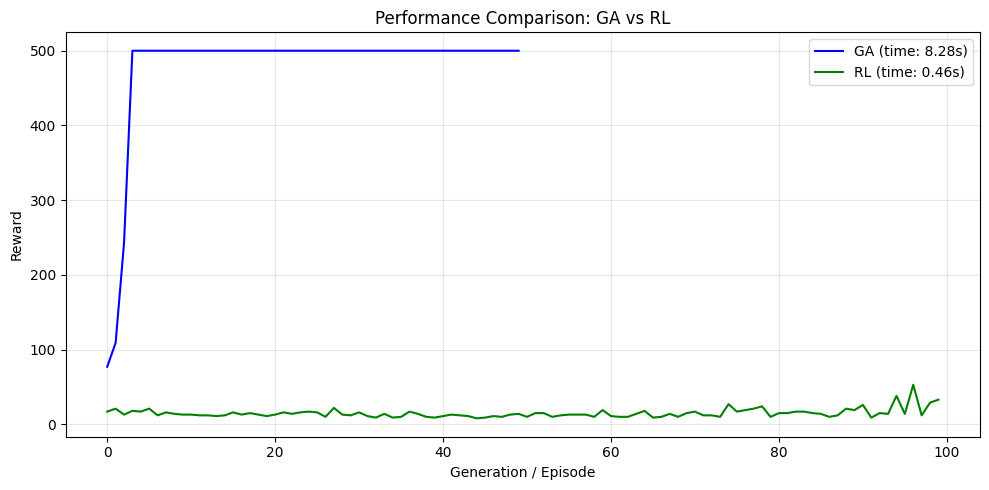

In [108]:
def main():
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    # GA训练
    ga_start = time.time()
    ga = GA(pop_size=50, generations=50)
    best_genotype, ga_history = ga.evolve()
    ga_time = time.time() - ga_start

    # RL训练
    rl_start = time.time()
    rl_trainer = RLTrainer(env)
    rl_history = rl_trainer.train(episodes=100)
    rl_time = time.time() - rl_start

    # 保存录像
    record_video(gym.make("CartPole-v1", render_mode="rgb_array"), None, is_ga=True, genotype=best_genotype, filename="ga_agent.gif")
    record_video(gym.make("CartPole-v1", render_mode="rgb_array"), rl_trainer.agent, is_ga=False, filename="rl_agent.gif")

    # 绘制对比图
    compare_results(ga_history, rl_history, ga_time, rl_time)

if __name__ == "__main__":
    main()